<a href="https://colab.research.google.com/github/muhammadnouman911/Pretrained-model-for-Audio-Classification/blob/main/Pretrained_Model_(VGGish)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  ESC-50 Audio Classification with Pretrained Model (VGGish) and Web Interface

 ============================================
# STEP 1: INSTALL REQUIRED LIBRARIES
 ============================================

In [ ]:
!pip install librosa matplotlib pandas scikit-learn tensorflow gradio tensorflow_hub --quiet


 ============================================
# STEP 2: IMPORT LIBRARIES
 ============================================

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import IPython.display as ipd
from io import BytesIO
from PIL import Image
import tensorflow as tf
import gradio as gr


 ============================================
# STEP 3: MOUNT GOOGLE DRIVE
 ============================================

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 ============================================
# STEP 4: SET PATHS
 ============================================

In [ ]:
DATA_PATH = '/content/drive/MyDrive/ESC-50/ESC-50-master'
AUDIO_PATH = DATA_PATH + '/audio'
META_PATH = DATA_PATH + '/meta/esc50.csv'

 ============================================
# STEP 5: LOAD METADATA
 ============================================

In [ ]:
metadata = pd.read_csv(META_PATH)
display(metadata.head())

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


 ============================================
# STEP 6: FEATURE EXTRACTION USING VGGish
 ============================================
# Download pretrained VGGish model

In [ ]:
vggish_model = hub.load('https://tfhub.dev/google/vggish/1')

# Function to extract log-mel spectrogram and use VGGish

In [ ]:
def extract_vggish_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    if len(y) < sr:
        y = np.pad(y, (0, sr - len(y)))
    else:
        y = y[:sr]  # 1-second audio

    waveform = tf.convert_to_tensor(y, dtype=tf.float32)
    embedding = vggish_model(waveform)
    return embedding.numpy().mean(axis=0)

X = []
y = []

for i, row in metadata.iterrows():
    try:
        file_path = os.path.join(AUDIO_PATH, row['filename'])
        label = row['category']
        features = extract_vggish_features(file_path)
        X.append(features)
        y.append(label)
    except Exception as e:
        print("Error in file:", row['filename'], "|", str(e))

X = np.array(X)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)


# Split

In [ ]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=test_size, random_state=42, stratify=y_cat)


# STEP 7: CLASSIFIER ON TOP OF VGGish FEATURES


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(50, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,018 (109.45 KB)

 Trainable params: 28,018 (109.45 KB)

 Non-trainable params: 0 (0.00 B)

 ============================================
# STEP 8: TRAIN MODEL
 ============================================

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stop])


Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0260 - loss: 4.0038 - val_accuracy: 0.1475 - val_loss: 3.6859
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0836 - loss: 3.6667 - val_accuracy: 0.2500 - val_loss: 3.2383
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1828 - loss: 3.2680 - val_accuracy: 0.3250 - val_loss: 2.7778
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2741 - loss: 2.8606 - val_accuracy: 0.4225 - val_loss: 2.4290
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3258 - loss: 2.5651 - val_accuracy: 0.4725 - val_loss: 2.1657
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3753 - loss: 2.3011 - val_accuracy: 0.4950 - val_loss: 2.0085
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3755 - loss: 2.2130 - val_accuracy: 0.5100 - val_loss: 1.8631
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4330 - loss: 2.0123 - val_accuracy: 0.5525 - val_loss:

# STEP 9: EVALUATE & PLOT RESULTS


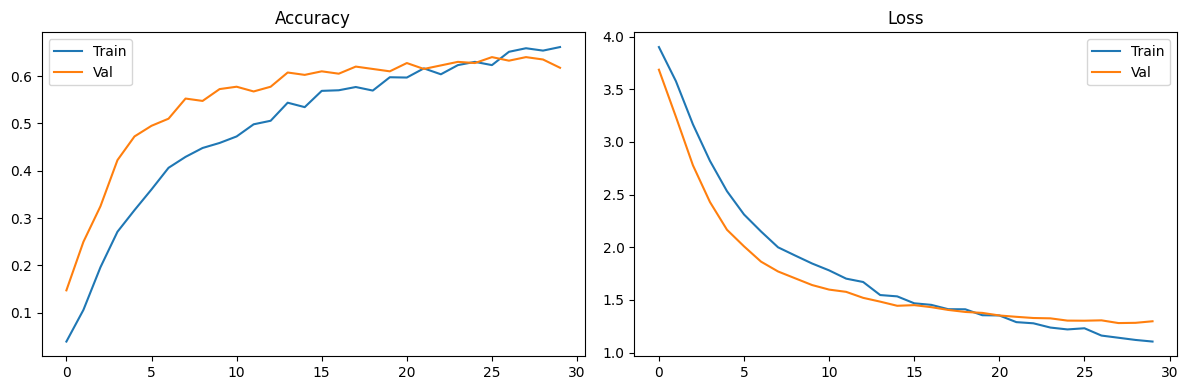

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate final accuracy

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {acc*100:.2f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6405 - loss: 1.3100 
Final Test Accuracy: 64.00%


 ============================================
# STEP 10: PREDICT ON CUSTOM FILE
 ============================================

In [ ]:
def predict_file(file_path):
    features = extract_vggish_features(file_path)
    features = features[np.newaxis, ...]  # add batch dim
    prediction = model.predict(features)
    class_index = np.argmax(prediction)
    return le.classes_[class_index]


# ============================================
# STEP 11: GENERATE MEL SPECTROGRAM IMAGE
# ============================================

In [ ]:
def generate_spectrogram_image(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()

    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    return Image.open(buf)


# ============================================
# STEP 12: GRADIO WEB INTERFACE
# ============================================

In [ ]:
def classify_audio_gradio(file_path):
    pred = predict_file(file_path)
    spectrogram_img = generate_spectrogram_image(file_path)
    return f"Predicted class: {pred}", spectrogram_img

audio_interface = gr.Interface(
    fn=classify_audio_gradio,
    inputs=gr.Audio(type="filepath"),
    outputs=[
        gr.Text(label="Predicted Class"),
        gr.Image(label="Mel Spectrogram")
    ],
    title="ESC-50 Audio Classifier (VGGish)",
    description="Upload a .wav audio file to classify its environmental sound category and see its mel spectrogram."
)

audio_interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4698cf329295509269.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
